In [7]:
import keras

Adesso posso caricare il modello addestrato in precedenza e preoccuparmi semplicemente dell'output dell'ultima rete convoluzionale. Dal summary si può notare che l'ultima layer convoluzionale emette 500 valori relativi alle attivazioni, questi saranno quindi le feature del nostro nuovo modello.

In [8]:
model = keras.saving.load_model("../models/modello-passi.keras")
final = keras.layers.Dense(1)(model.layers[-2].output)
attivazioni = keras.Model(inputs=model.layers[0].output,outputs=final)
attivazioni.summary()
attivazioni.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.R2Score()])
window = attivazioni.layers[0].output.shape[1]
out = attivazioni.layers[-1].input.shape[1]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 48, 20)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,801 (26.57 KB)

 Trainable params: 6,801 (26.57 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import pandas as pd

dati = pd.read_csv("../data/scalati.csv.gz")[:100000].dropna()

Questa sotto è una visualizzazione delle attivazioni della rete in risposta all'input mostrato

Preparo di nuovo i dati dei passi che dovrò dare in pasto alla rete per ottenere le attivazioni. Quelle attivazioni saranno poi i dati di training per il prossimo modello.

In [4]:
import numpy as np

xtrain = []
ytrain = []
xtest=[]
ytest=[]
test_ratio=0.1
for uuid, group in dati.groupby('uuid')[["date","n_steps","n_sleep_score"]]:
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    inputs = np.array(group[["date","n_steps"]].values)
    output = np.array(group["n_sleep_score"].values)


    for i in range (window,split):
        xtrain.append(inputs[i-window:i]) # Una finestra di <window> osservazioni sui passi
        ytrain.append(output[i]) # La qualità del sonno alla fine della finestra

    for i in range (split,len(group)):
        xtest.append(inputs[i-window:i])
        ytest.append(output[i])

xtrain=np.array(xtrain).reshape(-1,window,2)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,2)
ytest=np.array(ytest).reshape(-1,1)

Converto le osservazioni sui passi in una serie di attivazioni, da usare come input per il modello. Visto che 500 sono un po' tante ho provato anche a ridurre la dimensionalità con PCA

In [9]:
from keras.src.callbacks import EarlyStopping,ModelCheckpoint

history = attivazioni.fit(xtrain, ytrain, epochs=20, verbose=1, validation_split=.2,
                    callbacks=[EarlyStopping(monitor='val_r2_score', patience=5),
                               ModelCheckpoint(filepath='best_model.keras', monitor='val_r2_score',
                                               save_best_only=True)])

Epoch 1/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0150 - r2_score: -0.0013 - val_loss: 1.0187 - val_r2_score: -6.4552e-04
Epoch 2/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0039 - r2_score: 3.9336e-05 - val_loss: 1.0187 - val_r2_score: -6.2931e-04
Epoch 3/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0284 - r2_score: 5.3252e-05 - val_loss: 1.0188 - val_r2_score: -7.4565e-04
Epoch 4/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9931 - r2_score: 0.0011 - val_loss: 1.0194 - val_r2_score: -0.0013
Epoch 5/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0188 - r2_score: 0.0017 - val_loss: 1.0180 - val_r2_score: -1.0729e-06
Epoch 6/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0009 - r2_score: 0.0043 - val_loss: 1.0197 - val_r2_score: -0.0017
Epoch 7/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0114 - r2_score: 0.0043 - val_loss: 1.0182 - val_r2_score: -1.6785e-04
Epoch 8/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step 

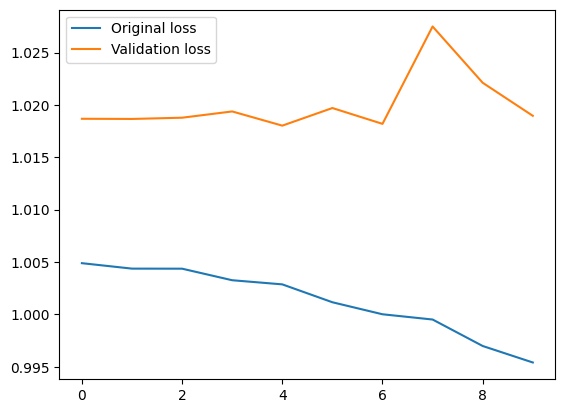

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [11]:
model.evaluate(xtest, ytest, batch_size=32)


305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0500 - r2_score: -0.0205


[1.011433482170105, -0.022174358367919922]

In [15]:
dati = pd.read_csv("../data/scalati.csv.gz")[-10000:].dropna()


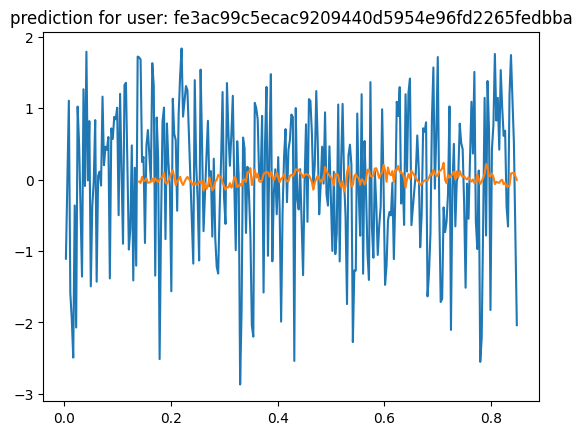

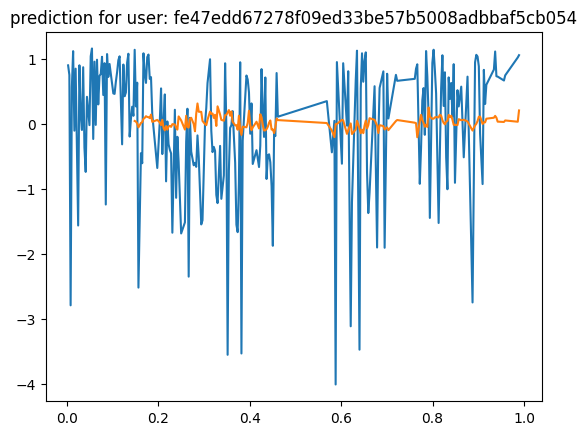

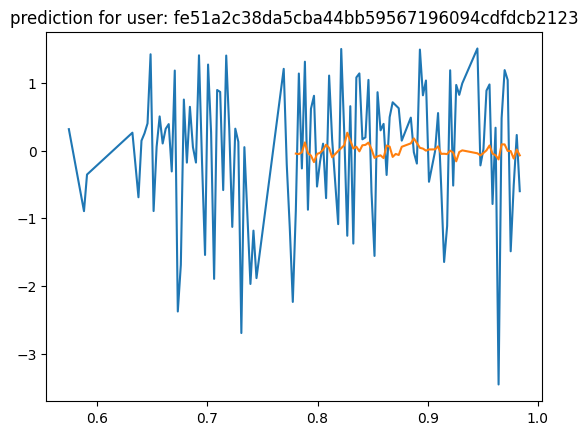

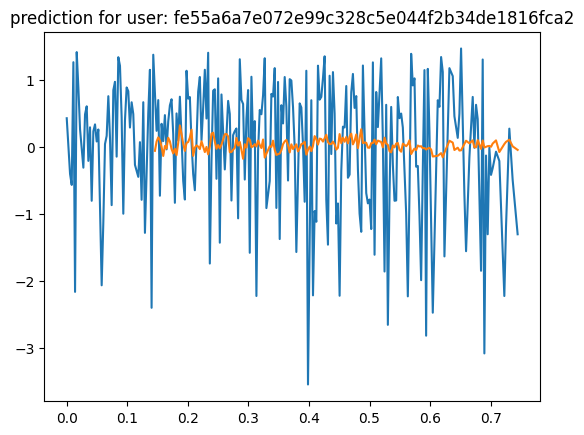

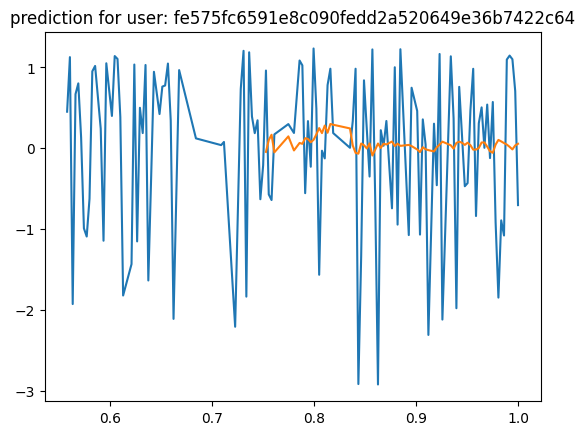

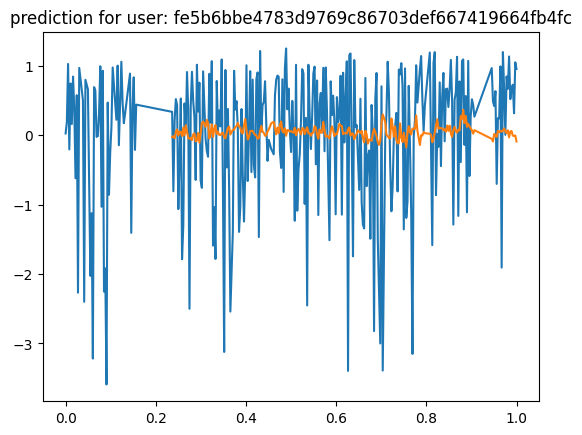

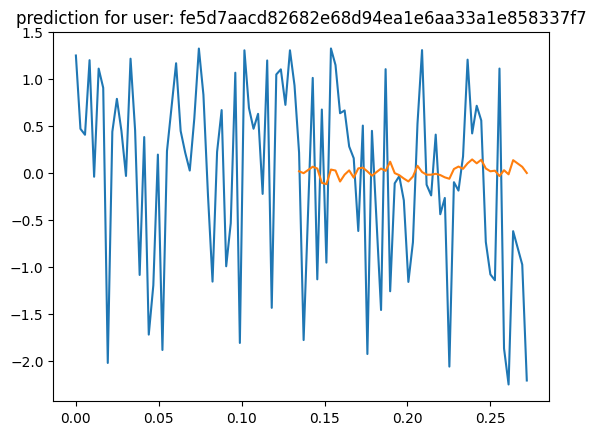

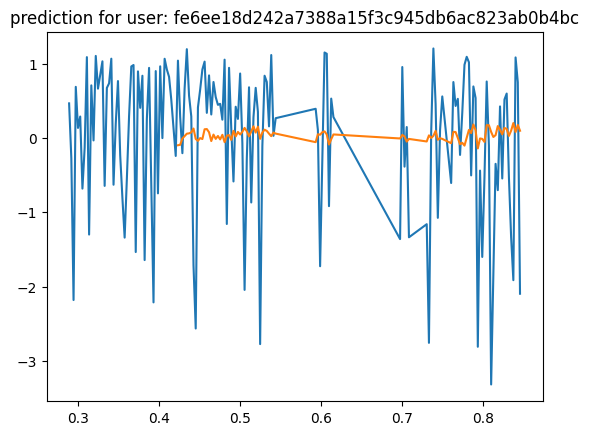

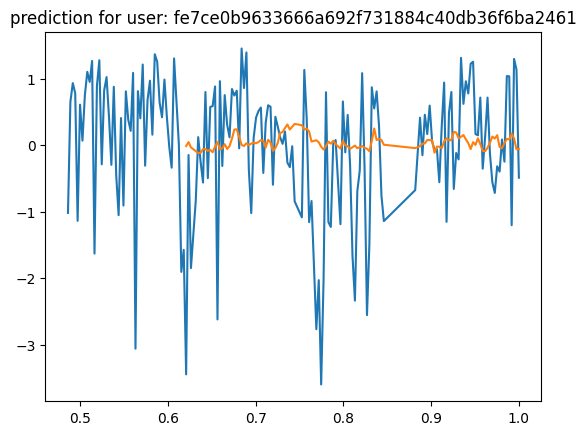

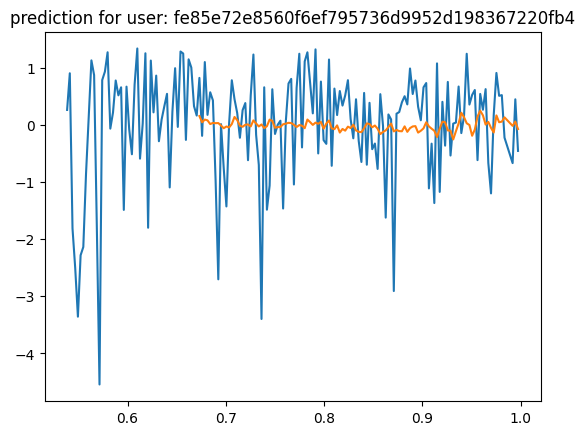

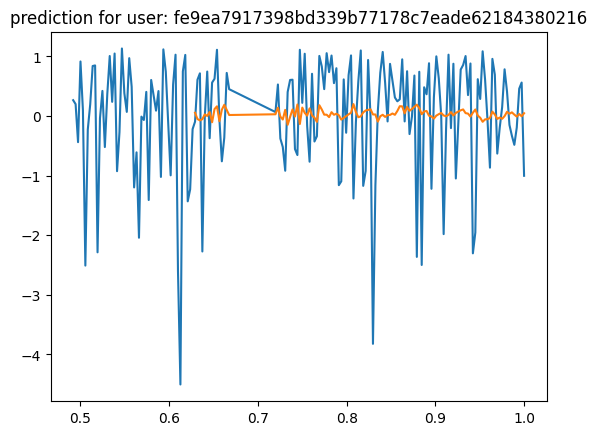

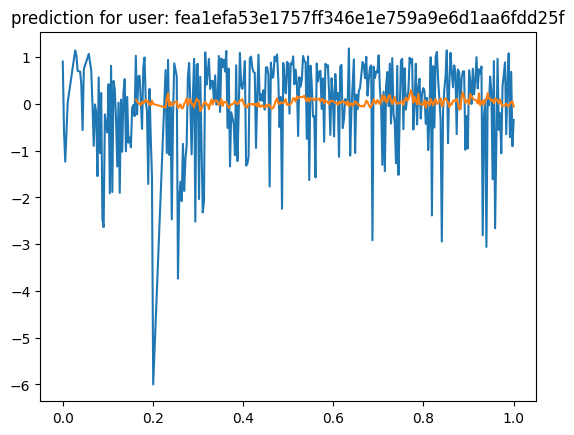

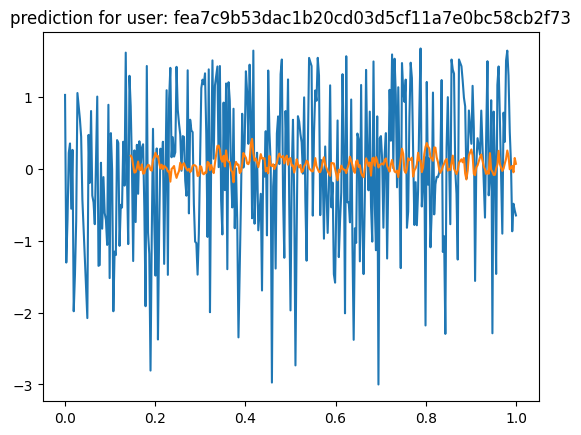

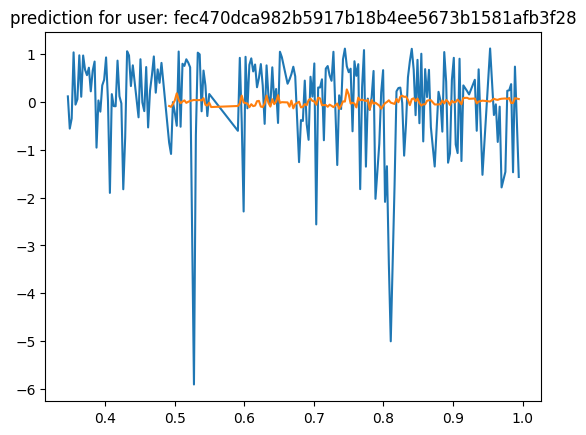

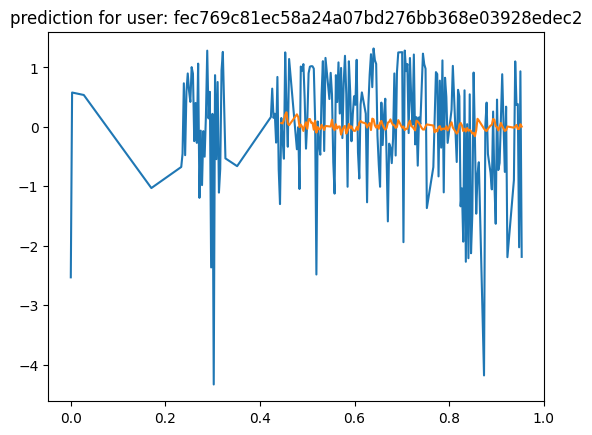

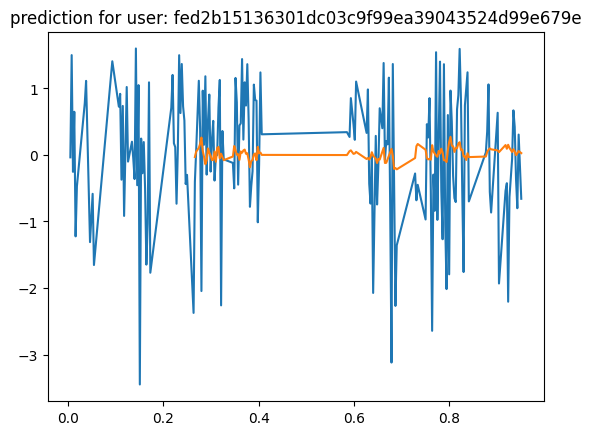

KeyboardInterrupt: 

In [21]:
for uuid,group in dati.groupby('uuid'):
    if len(group)<2*window:
        continue
    common = group[['date',"n_steps"]].values
    data=[]
    for i in range(window,len(common)):
        data.append([common[i-window:i]])
    data=np.array(data).reshape(-1,window,2)
    attivaz=attivazioni.predict_on_batch(data)
    plt.title("prediction for user: "+uuid)
    plt.plot(group.date.values,group.n_sleep_score.values,label='Actual')
    plt.plot(group.date.values[window:],attivaz,label='Predicted')
    plt.show()
    plt.close()